<a href="https://colab.research.google.com/github/KubatyM129/Learning_PyTorch_and_ML/blob/main/ComputerVision%20-%20CNN%20and%20non-linear.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [140]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import time
import torchvision
import pandas as pd
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
from torch import nn
from tqdm.auto import tqdm

In [113]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [114]:
# Traning Data
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
    target_transform=None
)
# Testing data
testing_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
    target_transform=None
)

In [115]:
class_names = training_data.classes
class_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

torch.Size([1, 28, 28])


(-0.5, 27.5, 27.5, -0.5)

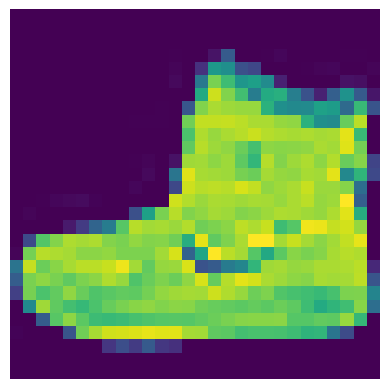

In [116]:
img, label = training_data[0]
print(img.shape)
plt.imshow(img.squeeze())
plt.axis(False)

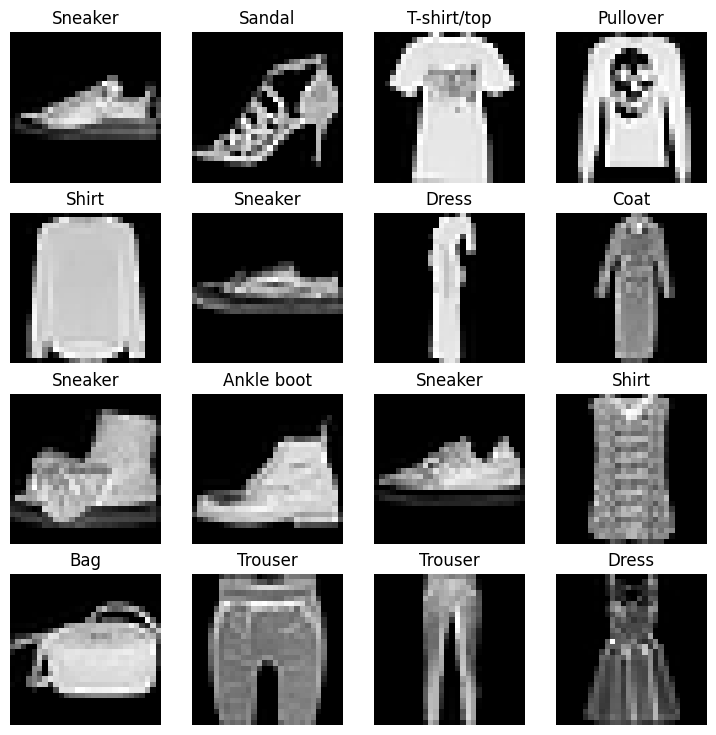

In [117]:
fig = plt.figure(figsize=(9,9))
rows, cols = 4,4
for i in range(1, rows*cols+1):
  img, label = training_data[torch.randint(0, len(training_data), size=[1]).item()]
  fig.add_subplot(rows, cols, i)
  plt.imshow(img.squeeze(), cmap="gray")
  plt.title(class_names[label])
  plt.axis(False)

In [118]:
BATCH_SIZE = 32
training_dataloader = DataLoader(training_data, BATCH_SIZE, True)
testing_dataloader = DataLoader(testing_data, BATCH_SIZE, False)

(-0.5, 27.5, 27.5, -0.5)

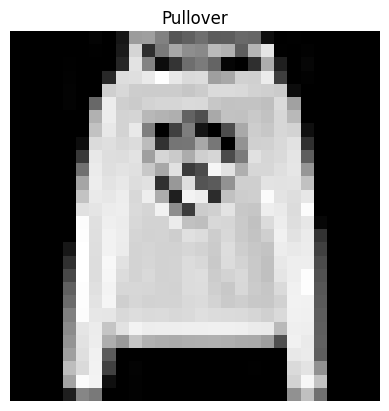

In [119]:
training_features_batch, training_labels_batch = next(iter(training_dataloader))

torch.manual_seed(42)
random_idx = torch.randint(0, len(training_features_batch), size=[1]).item()
img, label = training_features_batch[random_idx], training_labels_batch[random_idx]
plt.imshow(img.squeeze(), cmap="gray")
plt.title(class_names[label])
plt.axis(False)

In [120]:
class FashionModelV1(nn.Module):
  def __init__(
      self,
      input_shape: int,
      hidden_units: int,
      output_shape:int
               ):
    super().__init__()
    self.layer_stack = nn.Sequential(
        nn.Flatten(),
        nn.Linear(input_shape, hidden_units),
        nn.ReLU(),
        nn.Linear(hidden_units, output_shape)
    )
  def forward(self, x):
    return self.layer_stack(x)

In [121]:
torch.manual_seed(42)
model_1 = FashionModelV1(784,10,len(class_names)).to(device)

In [122]:
def accuracy(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = (correct / len(y_pred))*100
  return acc

In [123]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_1.parameters(), lr=0.1)

In [124]:
def training_time(
    start: float,
    end: float,
    device: torch.device = None):
  total_time = end -start
  return total_time

In [125]:
def training(model: torch.nn.Module,
              data_loader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              optimizer: torch.optim.Optimizer,
              accuracy_fn,
              device: torch.device = device):
    train_loss, train_acc = 0, 0
    model.to(device)
    for batch, (X, y) in enumerate(data_loader):
        X, y = X.to(device), y.to(device)

        y_pred = model(X)

        loss = loss_fn(y_pred, y)
        train_loss += loss
        train_acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")

In [126]:
def testing(model: torch.nn.Module,
            data_loader: torch.utils.data.DataLoader,
            loss_fn: torch.nn.Module,
            accuracy_fn,
            device: torch.device = device):
    test_loss, test_acc = 0, 0
    model.to(device)
    model.eval()
    with torch.inference_mode():
        for X, y in data_loader:

            X, y = X.to(device), y.to(device)

            test_pred = model(X)

            test_loss += loss_fn(test_pred, y)
            test_acc += accuracy_fn(y_true=y, y_pred=test_pred.argmax(dim=1))

        test_loss /= len(data_loader)
        test_acc /= len(data_loader)
    return {"model_name": model.__class__.__name__,
            "model_loss": test_loss.item(),
            "model_acc": test_acc}

In [127]:
training_start_time = time.time()
model_1.to(device)
epochs = 5
for epoch in tqdm(range(epochs)):
  training(model_1, training_dataloader, loss_fn, optimizer, accuracy)
model_1_result = testing(model_1, testing_dataloader, loss_fn, accuracy)
training_end_time = time.time()
training_time(training_start_time, training_end_time)

  0%|          | 0/5 [00:00<?, ?it/s]

Train loss: 0.64429 | Train accuracy: 77.08%
Train loss: 0.47890 | Train accuracy: 83.01%
Train loss: 0.44470 | Train accuracy: 84.30%
Train loss: 0.42667 | Train accuracy: 85.13%
Train loss: 0.41444 | Train accuracy: 85.37%


59.68859267234802

In [128]:
class CNNFashionModel(nn.Module):
  def __init__(self, input_shape: int, output_shape:int):
    super().__init__()
    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(input_shape, 6, kernel_size=5, stride=1, padding=2),
        nn.ReLU(),
        nn.AvgPool2d(kernel_size=2, stride=2),
        nn.Conv2d(6, 16, kernel_size=5, stride=1),
        nn.ReLU(),
        nn.AvgPool2d(kernel_size=2, stride=2),
        nn.Conv2d(16, 120, kernel_size=5, stride=1),
    )

    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(120, 84),
        nn.ReLU(),
        nn.Linear(84,output_shape),
        nn.ReLU()
    )

  def forward(self, x):
    return self.classifier(self.conv_block_1(x))

In [129]:
torch.manual_seed(42)
model_2 = CNNFashionModel(1, len(class_names)).to(device)

In [130]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_2.parameters(), lr=0.1)

In [131]:
training_start_time = time.time()
model_2.to(device)
epochs = 5
for epoch in tqdm(range(epochs)):
  training(model_2, training_dataloader, loss_fn, optimizer, accuracy)
model_2_result = testing(model_2, testing_dataloader, loss_fn, accuracy)
training_end_time = time.time()
training_time(training_start_time, training_end_time)

  0%|          | 0/5 [00:00<?, ?it/s]

Train loss: 0.78714 | Train accuracy: 70.89%
Train loss: 0.41388 | Train accuracy: 84.81%
Train loss: 0.36078 | Train accuracy: 86.74%
Train loss: 0.32989 | Train accuracy: 87.83%
Train loss: 0.30550 | Train accuracy: 88.78%


153.82213044166565

In [133]:
print(model_1_result)
print(model_2_result)

{'model_name': 'FashionModelV1', 'model_loss': 0.4554736912250519, 'model_acc': 84.23522364217253}
{'model_name': 'CNNFashionModel', 'model_loss': 0.3255212903022766, 'model_acc': 87.91932907348243}


In [138]:
pd.DataFrame([model_1_result, model_2_result])

,model_name,model_loss,model_acc
0,FashionModelV1,0.455474,84.235224
1,CNNFashionModel,0.325521,87.919329


In [141]:
try:
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")
    assert int(mlxtend.__version__.split(".")[1]) >= 19, "mlxtend verison should be 0.19.0 or higher"
except:
    !pip install -q torchmetrics -U mlxtend # <- Note: If you're using Google Colab, this may require restarting the runtime
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 868.8/868.8 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 35.6 MB/s eta 0:00:00
mlxtend version: 0.23.1


In [143]:
y_preds = []
model_2.eval()
with torch.inference_mode():
  for X, y in tqdm(testing_dataloader, desc="Making predictions"):
    # Send data and targets to target device
    X, y = X.to(device), y.to(device)
    # Do the forward pass
    y_logit = model_2(X)
    # Turn predictions from logits -> prediction probabilities -> predictions labels
    y_pred = torch.softmax(y_logit, dim=1).argmax(dim=1) # note: perform softmax on the "logits" dimension, not "batch" dimension (in this case we have a batch size of 32, so can perform on dim=1)
    # Put predictions on CPU for evaluation
    y_preds.append(y_pred.cpu())
# Concatenate list of predictions into a tensor
y_pred_tensor = torch.cat(y_preds)

Making predictions:   0%|          | 0/313 [00:00<?, ?it/s]

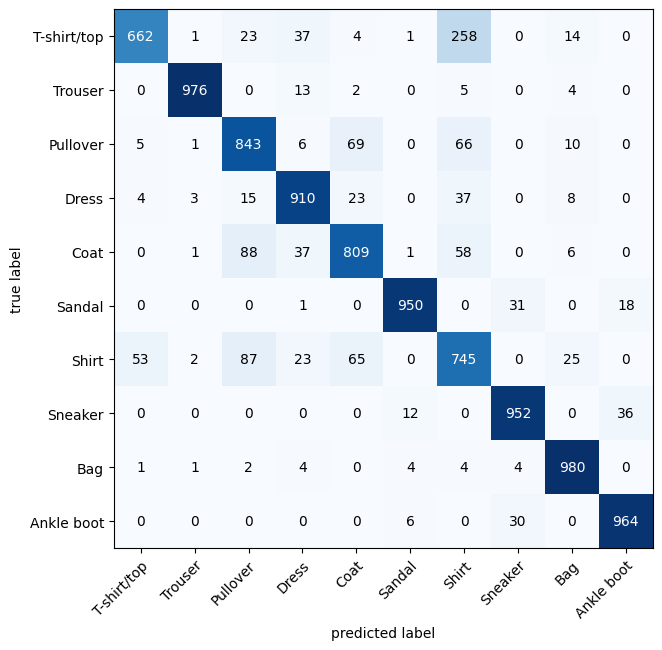

In [147]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

confmat = ConfusionMatrix(num_classes=len(class_names), task='multiclass')
confmat_tensor = confmat(preds=y_pred_tensor,
                         target=testing_data.targets)


fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(),
    class_names=class_names,
    figsize=(10, 7)
);